### Data preparation


First, we load a black and white image of Laika and convert it into a binary matrix of 1 and -1. So that white pixels have value 1 and black pixels have value -1.

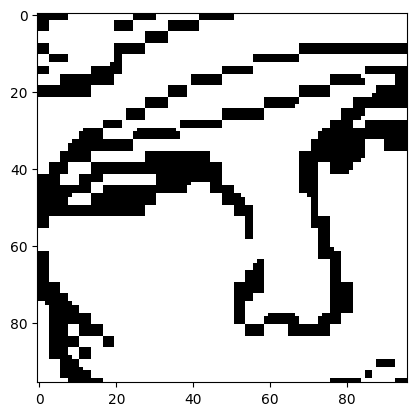

In [28]:
!pip install wget

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import PIL.Image as Image
from os.path import exists
from wget import download
from tqdm import tqdm
filename, url = "/content/astronaut.png", "https://i.redd.it/astronaut.png"

def load_img():
    if not exists(filename):
        download(url)

    with open(filename, 'rb') as fp:
        img2 = Image.open(fp).convert('L')
        img2 = np.array(img2)
    return (img2[:96,11:107] > 120) * 2.0 - 1

img_true = load_img()
plt.imshow(img_true, cmap='gray')

To introduce noise into the image, for each pixel, swap its value between 1 and -1 with rate 0.2.


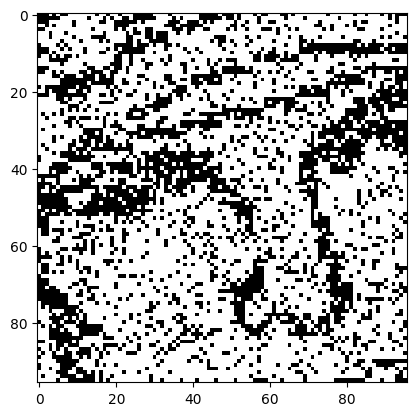

In [29]:
def gen_noisyimg(img, noise=.05):
    swap = np.random.binomial(1, noise, size=img.shape)
    return img * (2 * swap - 1)

noise = 0.2
img_noisy = gen_noisyimg(img_true, noise)
plt.imshow(-1 * img_noisy, cmap='gray')

### The Loopy BP algorithm


### Initialization


In [30]:
y = img_noisy.reshape([img_true.size, ])
num_nodes = len(y)
init_message = np.zeros([2, num_nodes, num_nodes]) + .5
J = 1.0
beta = 1.0

Then we find the neighboring pixels around a given pixel, which will be used for BP updates

In [31]:
def get_neighbors_of(node):
    """
    arguments:
     int node:  in [0,num_nodes) index of node to query
    globals:
     int num_nodes: number of nodes
    return: set(int) indices of neighbors of queried node
    """
    neighbors = []
    m = int(np.sqrt(num_nodes))
    if (node + 1) % m != 0:
        neighbors += [node + 1]
    if node % m != 0:
        neighbors += [node - 1]
    if node + m < num_nodes:
        neighbors += [node + m]
    if node - m >= 0:
        neighbors += [node - m]

    return set(neighbors)

In [32]:
def get_message(node_from, node_to, messages):
    """
    arguments:
     int node_from: in [0,num_nodes) index of source node
     int node_from: in [0,num_nodes) index of target node
     float array messages: (2, num_nodes, num_nodes), messages[:,j,i] is message
                           from node j to node i
    reads globals:
     float array y: (num_nodes,) observed pixel values
     float J: clique coupling strength constant
     float beta: observation to true pixel coupling strength constant
    return: array(float) of shape (2,) un-normalized message from node_from to
    node_to
    """
    #TODO: implement your function here
    x = [1, -1]
    nbrs = get_neighbors_of(node_from)
    pos = 1
    neg = 1
    rtrn = []

    for k in nbrs:
      pos *= messages[0, k, node_from]

    for k in nbrs:
      neg *= messages[1, k, node_from]

    for i in range(2):
      a = np.exp(beta * 1 * y[node_from])
      b = np.exp(J * x[i] * 1)

      c = np.exp(beta * -1 * y[node_from])
      d = np.exp(J * x[i] * -1)
      rtrn.append(a * b * pos + c * d * neg)

    return rtrn


def step_bp(step, messages):
    """
    arguments:
     float step: step size to update messages
    return
     float array messages: (2, num_nodes, num_nodes), messages[:,j,i] is message
                           from node j to node i
    """
    for node_from in range(num_nodes):
        for node_to in get_neighbors_of(node_from):
            m_new = get_message(node_from, node_to, messages)
            # normalize
            m_new = m_new / np.sum(m_new)

            messages[:, node_from, node_to] = step * m_new + (1. - step) * \
                messages[:, node_from, node_to]
    return messages

Then, run loopy BP update for 10 iterations:

In [33]:
num_iter = 10
step = 0.5
for it in range(num_iter):
    init_message = step_bp(step, init_message)
    print(it + 1,'/',num_iter)

1 / 10
2 / 10
3 / 10
4 / 10
5 / 10
6 / 10
7 / 10
8 / 10
9 / 10
10 / 10


In [34]:
def update_beliefs(messages):
    """
    arguments:
    float array messages: (2, num_nodes, num_nodes), messages[:,j,i] is message
                           from node j to node i
    reads globals:
     float beta: observation to true pixel coupling strength constant
     float array y: (num_nodes,) observed pixel values
    returns:
     float array beliefs: (2, num_nodes), beliefs[:,i] is the belief of node i
    """
    beliefs = np.zeros([2, num_nodes])
    cnt = 0
    for node in range(num_nodes):
        #TODO: implement belief calculation here
        nbrs = get_neighbors_of(node)
        pos, neg = 1, 1

        for k in nbrs:
          pos *= messages[0, k, node]

        for k in nbrs:
          neg *= messages[1, k, node]

        beliefs[0][cnt] = np.exp(beta * 1 * y[node]) * pos
        beliefs[1][cnt] = np.exp(beta * -1 * y[node]) * neg
        sum = beliefs[0][cnt] + beliefs[1][cnt]

        beliefs[0][cnt] /= sum
        beliefs[1][cnt] /= sum

        cnt += 1

    return beliefs

# call update_beliefs() once
beliefs = update_beliefs(init_message)

Finally, to get the denoised image, we use 0.5 as the threshold and consider pixel with belief less than threshold as black while others as white.

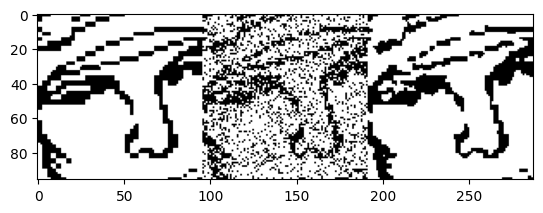

In [35]:
pred = 2. * ((beliefs[1, :] > .5) + .0) - 1.
img_out = pred.reshape(img_true.shape)

plt.imshow(np.hstack([img_true, -1*img_noisy, img_out]), cmap='gray')


This is the `test_trajectory` function which obtains predicted image after each step of message passing. Return predicted images as list.

In [36]:
def test_trajectory(step_size, max_step=10):
    """
    step_size: step_size to update messages in each iteration
    max_step: number of steps
    """
    # re-initialize each time
    messages = np.zeros([2, num_nodes, num_nodes]) + .5
    images = []

    # solution:
    for it in range(max_step):
      messages = step_bp(step_size, messages)
      beliefs = update_beliefs(messages)
      pred = 2. * ((beliefs[1, :] > .5) + .0) - 1.
      images.append(pred.reshape(img_true.shape))

    return images



We use the test_trajectory function to create image serieses for `step size` 0.1, 0.3, and 1.0, each with 10 steps and display these images with `plot_series' provided below.


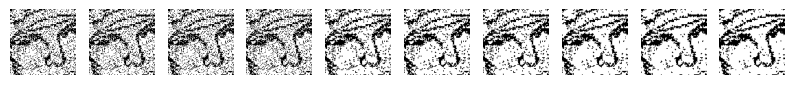

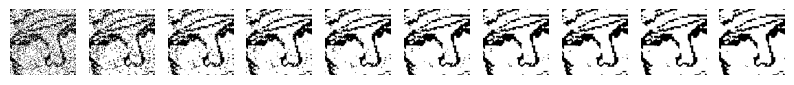

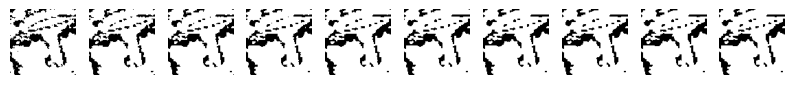

In [37]:
def plot_series(images):

  n = len(images)
  fig, ax = plt.subplots(1, n)
  for i in range(n):
    ax[i].imshow(images[i], cmap='gray')
    ax[i].set_axis_off()
  fig.set_figwidth(10)
  fig.show()

#Solution:

plot_series(test_trajectory(0.1))
plot_series(test_trajectory(0.3))
plot_series(test_trajectory(1.0))


Generating and displaying images with noise of 0.5 and 1


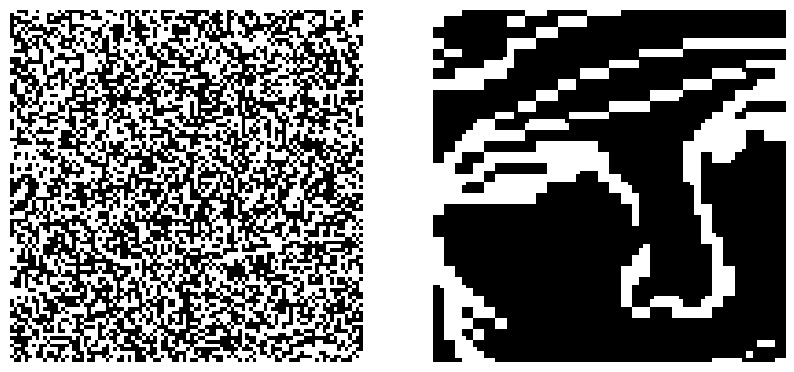

In [43]:
# Solution
imagesA = []
# imagesA.append(gen_noisyimg(img_true, 0.05))
# imagesA.append(gen_noisyimg(img_true, 0.3))
imagesA.append(gen_noisyimg(img_true, 0.5))
imagesA.append(gen_noisyimg(img_true, 1.0))
# plot_series(imagesA)

fig, ax = plt.subplots(1, 2)
for i in range(2):
  ax[i].imshow(-1 * imagesA[i], cmap='gray')
  ax[i].set_axis_off()
fig.set_figwidth(10)
fig.show()

Now we perform image denoising on images with noise levels $0.05$ and $0.3$ using using $J=0.1$, $J=0.5$, $J=1.0$, and $J=5.0$. Set step size to 0.8 and max_step to 5.

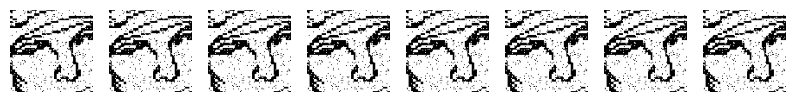

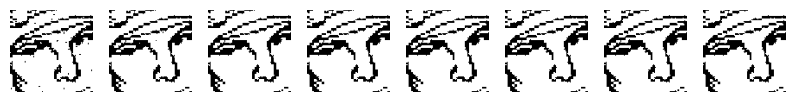

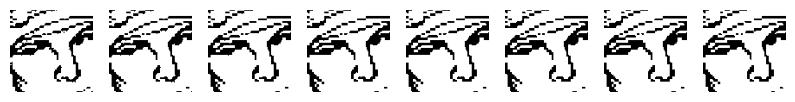

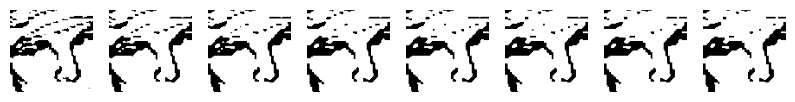

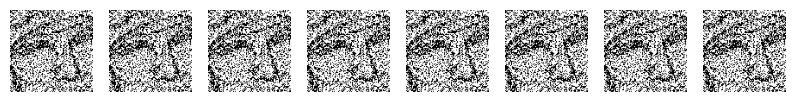

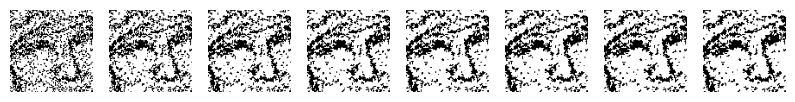

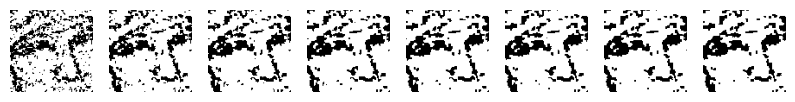

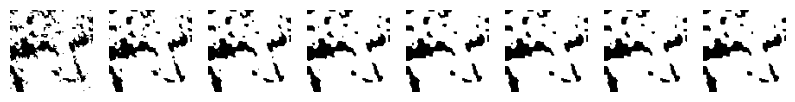

In [42]:
# Solution

J = 0.1
y = imagesA[0].reshape([img_true.size, ])
plot_series(test_trajectory(0.8, 8))
J = 0.5
plot_series(test_trajectory(0.8, 8))
J = 1.
plot_series(test_trajectory(0.8, 8))
J = 5.
plot_series(test_trajectory(0.8, 8))

J = 0.1
y = imagesA[1].reshape([img_true.size, ])
plot_series(test_trajectory(0.8, 8))
J = 0.5
plot_series(test_trajectory(0.8, 8))
J = 1.
plot_series(test_trajectory(0.8, 8))
J = 5.
plot_series(test_trajectory(0.8, 8))